## Install Kaggle and video dataset

In [1]:
!pip install -q kaggle
!kaggle datasets download hbahruz/multiple-lego-tracking-dataset

Dataset URL: https://www.kaggle.com/datasets/hbahruz/multiple-lego-tracking-dataset
License(s): other
 99% 1.68G/1.69G [00:21<00:00, 183MB/s]
100% 1.69G/1.69G [00:21<00:00, 85.1MB/s]


In [2]:
import zipfile

def extract_zip(file_path, extract_to='.'):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

extract_zip('multiple-lego-tracking-dataset.zip', 'lego-tracking')

## Installing libraries

In [3]:
!pip install ultralytics deep_sort_realtime
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 100.1 MB/s eta 0:00:00


## Importing libraries

In [4]:
from ultralytics import RTDETR
from deep_sort_realtime.deepsort_tracker import DeepSort

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101

### Test - Detection model

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda



image 1/1 /content/lego-tracking/Lego_Tracking/Lego_Tracking/Train/Lego1/img1/frame0200.jpg: 384x640 12 class_0s, 130.8ms
Speed: 21.3ms preprocess, 130.8ms inference, 1329.2ms postprocess per image at shape (1, 3, 384, 640)


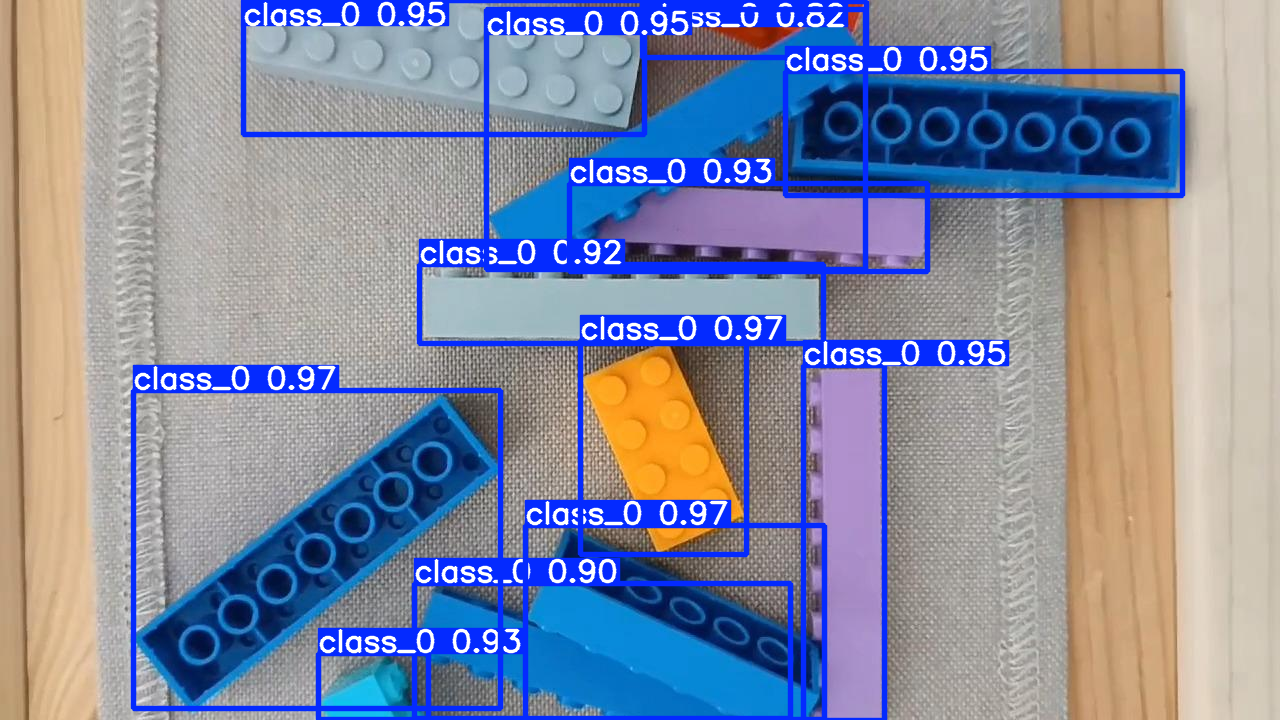

In [7]:
path_yolo_pt = "lego-tracking/Best_RT-DETR_PT_parameters/Best_RT-DETR_PT_parameters/"
model_ft = RTDETR(path_yolo_pt + "best.pt").to(device)

img_path = "lego-tracking/Lego_Tracking/Lego_Tracking/Train/Lego1/img1"
example = os.path.join(img_path, os.listdir(img_path)[1])
res = model_ft(example, conf = 0.77)

rgb_array = cv2.cvtColor(res[0].plot(), cv2.COLOR_BGR2RGB)
image = Image.fromarray(rgb_array)
im = image.convert("RGB")
im

### The pipeline - YOLOv8 + DeepLabv3 + DeepSORT

In [9]:
# Load the YOLO and DeepSort models
path_yolo_pt = "lego-tracking/Best_RT-DETR_PT_parameters/Best_RT-DETR_PT_parameters/"
model_ft = RTDETR(path_yolo_pt + "best.pt").to(device)
tracker = DeepSort(max_age=25)

# Load the segmentation model
segmentation_model = deeplabv3_resnet101(pretrained=False)
segmentation_model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1))  # Binary segmentation
state_dict = torch.load('lego-tracking/DeepLabV3_parameters/lego_segmentation_deeplabv3_epoch20.pth', map_location=torch.device('cpu'))
segmentation_model.load_state_dict(state_dict, strict=False)
segmentation_model.eval()
segmentation_model.to(device)

image_path = 'lego-tracking/Lego_Tracking/Lego_Tracking/Train/Lego4/img1/frame0140.jpg'

### Test the pipeline

In [11]:
detections = model(image_path)

boxes = detections[0].boxes.xyxy.cpu().numpy()
scores = detections[0].boxes.conf.cpu().numpy()


image 1/1 /content/lego-tracking/Lego_Tracking/Lego_Tracking/Train/Lego4/img1/frame0140.jpg: 384x640 8 class_0s, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


0.44579947549963184
0.5977329122490412
0.6357602472513553
0.7898365679264555
0.5011978176535139
0.6924908424908425
0.34926396450897357
0.7455436720142602


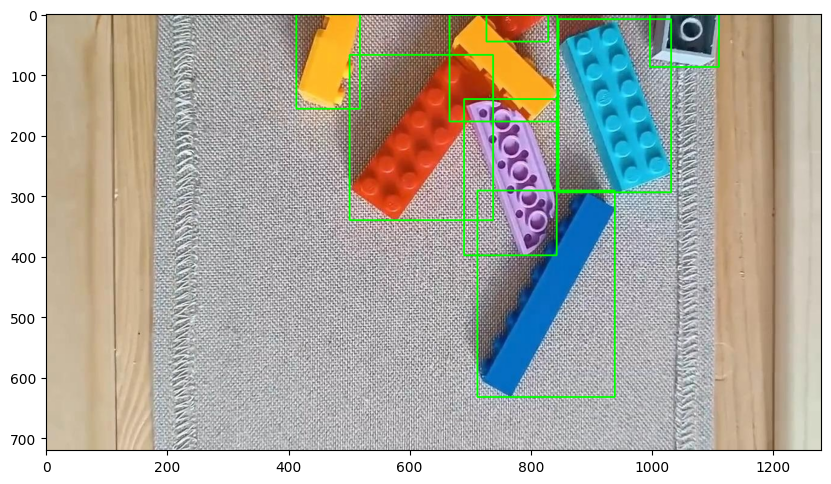

In [12]:
image = Image.open(image_path).convert('RGB')
image_rgb = np.array(image)

transform = transforms.Compose([
    transforms.ToTensor(),
])

image_tensor = transform(image_rgb).unsqueeze(0).to(device)

with torch.no_grad():
    output = segmentation_model(image_tensor)['out'][0]
    output = torch.sigmoid(output).cpu().numpy()

mask = (output > 0.5).astype(np.uint8)[0]
mask = cv2.resize(mask, (image_rgb.shape[1], image_rgb.shape[0]))
filtered_boxes = []

# Loop through the YOLO detections and filter based on segmentation mask overlap
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = map(int, box)

    # Extract the region of the mask corresponding to the detection box
    mask_region = mask[y1:y2, x1:x2]

    # Calculate the number of white pixels (indicating egg presence) in the mask region
    white_pixel_count = np.sum(mask_region == 1)

    detection_pixel_count = (y2 - y1) * (x2 - x1)
    overlap_ratio = white_pixel_count / detection_pixel_count

    print(overlap_ratio)
    if overlap_ratio > 0.1:  # Keep detection if enough overlap with the mask
        filtered_boxes.append(box)



image_with_detections = image_rgb.copy()

for box in filtered_boxes:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image_with_detections, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(image_with_detections)
plt.show()

## PipeLine

In [13]:
# Load the YOLO and DeepSort models
path_yolo_pt = "lego-tracking/Best_RT-DETR_PT_parameters/Best_RT-DETR_PT_parameters/"
model_ft = RTDETR(path_yolo_pt + "best.pt").to(device)
tracker = DeepSort(max_age=25)

# Load the segmentation model
segmentation_model = deeplabv3_resnet101(pretrained=False)
segmentation_model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1))  # Binary segmentation
state_dict = torch.load('lego-tracking/DeepLabV3_parameters/lego_segmentation_deeplabv3_epoch20.pth', map_location=torch.device('cpu'))
segmentation_model.load_state_dict(state_dict, strict=False)
segmentation_model.eval()
segmentation_model.to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
])

In [15]:
base_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test"
test_videos = os.listdir(base_path)
test_videos.sort()
test_videos

['Lego1', 'Lego2']

In [19]:
import re

def detect_and_track(train_video, model, segmentation_model, tracker, pred_conf, fps = 25.0):
    video_frames = os.path.join(base_path, f"{train_video}/img1")

    # Prepare to record the video
    first_frame_path = os.path.join(video_frames, 'frame0001.jpg')
    first_frame = cv2.imread(first_frame_path)
    frame_height, frame_width = first_frame.shape[:2]

    video_output = os.path.join('/content/', f'{train_video}_tracked.mp4')
    video_writer = cv2.VideoWriter(video_output, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    tracking_results = []
    unique_track_ids = set()
    frame_pattern = re.compile(r'frame(\d+)\.jpg')
    frames = os.listdir(video_frames)
    frames_sorted = sorted(frames, key=lambda x: int(frame_pattern.match(x).group(1)))

    for frame_id, frame_name in enumerate(frames_sorted):
        frame_path = os.path.join(video_frames, frame_name)
        frame = cv2.imread(frame_path)

        result_frame = model(frame, conf=pred_conf)
        detections = result_frame[0].boxes.xyxy.cpu().numpy()
        confidences = result_frame[0].boxes.conf.cpu().numpy()

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image_tensor = transform(image_rgb).unsqueeze(0).to(device)

        with torch.no_grad():
            output = segmentation_model(image_tensor)['out'][0]
            output = torch.sigmoid(output).cpu().numpy()

        mask = (output > 0.5).astype(np.uint8)[0]
        mask = cv2.resize(mask, (image_rgb.shape[1], image_rgb.shape[0]))

        # Filter detections
        filtered_boxes = []
        for i, box in enumerate(detections):
            x1, y1, x2, y2 = map(int, box)
            mask_region = mask[y1:y2, x1:x2]

            # Calculate overlap between mask and detection
            white_pixel_count = np.sum(mask_region == 1)
            detection_pixel_count = (y2 - y1) * (x2 - x1)
            overlap_ratio = white_pixel_count / detection_pixel_count

            if overlap_ratio >= 0.1:
                filtered_boxes.append(box)

        formatted_detections = []
        for box, conf in zip(filtered_boxes, confidences):
            x1, y1, x2, y2 = map(int, box)
            width = x2 - x1
            height = y2 - y1
            # x_center = x1 + width / 2
            # y_center = y1 + height / 2
            formatted_detections.append(([x1, y1, width, height], conf, 0))

        tracks = tracker.update_tracks(formatted_detections, frame=frame)
        current_frame_object_count = 0

        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            x1, y1, x2, y2 = map(int, track.to_ltrb())
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            current_frame_object_count += 1
            unique_track_ids.add(track_id)
            tracking_results.append([frame_id, int(track_id), x1, y1, x2 - x1, y2 - y1])

        cv2.putText(frame, f"Objects in frame: {current_frame_object_count}", (5, 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        cv2.putText(frame, f"Unique objects: {len(unique_track_ids)}", (5, 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

        video_writer.write(frame)

    video_writer.release()
    return tracking_results

In [ ]:
tracking_results_dict = {}
for test_video in test_videos:
    print(5*"-------------------------------------------------------------------------------------------------------\n")
    print(f"Processing video: {test_video}")
    tracker = DeepSort(max_age=10, n_init = 3, nms_max_overlap = 0.8)
    tr_res = detect_and_track(test_video, model, segmentation_model, tracker, pred_conf=0.25)
    tracking_results_dict[test_video] = tr_res

## Metrics

In [21]:
!pip install motmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 6.6 MB/s eta 0:00:00


In [22]:
import motmetrics as mm

In [23]:
def load_ground_truth(gt_file):
    ground_truths = []
    with open(gt_file, 'r') as file:
        for line in file:
            parts = list(map(float, line.strip().split(',')))
            frame_id, obj_id, x, y, width, height = int(parts[0]), int(parts[1]), parts[2], parts[3], parts[4], parts[5]
            ground_truths.append([frame_id, obj_id, x, y, width, height])
    return np.array(ground_truths)

In [24]:
def evaluate_tracking(ground_truths, tracking_results):
    def results_to_motchallenge_format(results):
        return np.array([[r[0], -1, r[2], r[3], r[4], r[5], 1, -1, -1, -1] for r in results])

    gt_mot = results_to_motchallenge_format(ground_truths)
    tr_mot = results_to_motchallenge_format(tracking_results)

    acc = mm.MOTAccumulator(auto_id=True)

    gt_dict = {frame_id: [] for frame_id in np.unique(ground_truths[:, 0])}
    for gt in gt_mot:
        gt_dict[gt[0]].append(gt[1:])

    tr_dict = {frame_id: [] for frame_id in np.unique(tracking_results[:, 0])}
    for tr in tr_mot:
        tr_dict[tr[0]].append(tr[1:])

    for frame_id in gt_dict.keys():
        gt_frame = gt_dict[frame_id]
        tr_frame = tr_dict.get(frame_id, [])

        gt_ids = [gt[0] for gt in gt_frame]
        tr_ids = [tr[0] for tr in tr_frame]

        gt_bboxes = np.array([gt[1:5] for gt in gt_frame])
        tr_bboxes = np.array([tr[1:5] for tr in tr_frame])

        distances = mm.distances.iou_matrix(gt_bboxes, tr_bboxes, max_iou=1)

        acc.update(gt_ids, tr_ids, distances)

    mh = mm.metrics.create()
    summary = mh.compute(acc, metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_objects', 'num_matches', 'num_false_positives', 'num_misses', 'num_switches'])

    strsummary = mm.io.render_summary(summary, formatters=mh.formatters)
    print(strsummary)

    return summary

In [25]:
main_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test"
gt_files = [os.path.join(main_path, vid, "gt.txt") for vid in os.listdir(main_path)]
gt_files.sort()
gt_files

['/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego1/gt.txt',
 '/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego2/gt.txt']

In [26]:
sorted_dict = dict(sorted(tracking_results_dict.items()))
print(sorted_dict)

{'Lego1': [[21, 1, 605, 0, 67, 37], [22, 1, 602, 0, 77, 44], [23, 1, 599, 0, 86, 49], [24, 1, 596, 0, 97, 57], [25, 1, 595, 0, 104, 61], [26, 1, 592, 0, 111, 67], [27, 1, 591, 0, 115, 70], [28, 1, 590, 0, 120, 75], [29, 1, 590, 0, 123, 79], [30, 1, 591, 0, 126, 82], [30, 2, 399, 0, 119, 69], [31, 1, 591, 0, 129, 86], [31, 2, 396, 0, 123, 72], [32, 1, 590, 0, 134, 92], [32, 2, 391, 0, 132, 78], [33, 1, 591, 0, 137, 96], [33, 2, 388, 0, 137, 82], [34, 1, 590, 0, 144, 103], [34, 2, 382, 0, 147, 89], [35, 1, 590, 0, 148, 109], [35, 2, 377, 0, 154, 95], [36, 1, 589, 0, 153, 115], [36, 2, 372, 0, 162, 102], [37, 1, 589, 0, 156, 120], [37, 2, 369, 0, 166, 106], [38, 1, 589, 0, 160, 126], [38, 2, 365, 0, 171, 112], [39, 1, 590, 0, 160, 128], [39, 2, 364, 0, 172, 115], [39, 3, 777, 0, 80, 37], [40, 1, 591, 0, 162, 133], [40, 2, 362, 0, 175, 119], [40, 3, 771, 0, 90, 42], [41, 1, 591, 0, 164, 136], [41, 2, 362, 0, 174, 122], [41, 3, 769, 0, 95, 45], [42, 1, 592, 0, 164, 140], [42, 2, 361, 0, 176

In [27]:
def aggregate_metrics(gt_files, tracking_results_dict):
    overall_acc = mm.MOTAccumulator(auto_id=True)

    dct = {}
    metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_objects', 'num_matches', 'num_false_positives', 'num_misses', 'num_switches']

    for gt_file, track_key in zip(gt_files, tracking_results_dict):
        print(gt_file, track_key)
        ground_truths = load_ground_truth(gt_file)
        tr_mot = np.array(tracking_results_dict[track_key])

        et = evaluate_tracking(ground_truths, tr_mot)
        for metric in metrics:
            dct[metric] = dct.get(metric, 0) + et[metric]


    for metric in metrics:
        dct[metric] /= len(gt_files)
    return pd.DataFrame(dct)

In [ ]:
aggregate_metrics(gt_files, sorted_dict)

### Same things can be applied for Training videos